Tully model 1 from [JCP **93**, 1061 (1990)](http://dx.doi.org/10.1063/1.459170). Details of this usage of the MMST matches that of Ananth et al. ([JCP **127**, 084114 (2007)](http://dx.doi.org/10.1063/1.2759932)). 

The potentials are:

$V_{11}(R) = V_0 \tanh(a R) \\
V_{22}(R) = -V_{11}(R) \\
V_{12}(R) = V_{21}(R) = C e^{-D(R+f)^2}$ 

with $V_0 = 0.01$, $a=1.6$, $C=0.005$, $D=1$, and $f=0$.

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit


sys11 = mm.openmm.System()
sys12 = mm.openmm.System()
sys22 = mm.openmm.System()
sys00 = mm.openmm.System()

for sys in [sys11, sys12, sys22, sys00]:
    mass = 1980.0 * unit.amu
    sys.addParticle(mass)

V11 = mm.openmm.CustomExternalForce("V0*tanh(a*x)")
V11.addGlobalParameter("V0", 0.01)
V11.addGlobalParameter("a", 1.6)
V11.addParticle(0, ())

V22 = mm.openmm.CustomExternalForce("-V0*tanh(a*x)")
V22.addGlobalParameter("V0", 0.01)
V22.addGlobalParameter("a", 1.6)
V22.addParticle(0, ())

V12 = mm.openmm.CustomExternalForce("C*exp(-D*(x+f))")
V12.addGlobalParameter("C", 0.005)
V12.addGlobalParameter("D", 1.0)
V12.addGlobalParameter("f", 0.0)
V12.addParticle(0, ())

V00 = mm.openmm.CustomExternalForce("0.0*x")
V00.addParticle(0, ())

sys00.addForce(V00)
sys11.addForce(V11)
sys12.addForce(V12)
sys22.addForce(V22)




topology = app.Topology()
dt = 5*46.0 * unit.femtoseconds 

init_pos = np.array([[-5.0, 0.0, 0.0]]) #* unit.nanometer
#init_vel = np.array([[19.9/1980.0, 0.0, 0.0]]) #* unit.nanometer / unit.picosecond
init_vel = np.array([[0.0022, 0.0, 0.0]])

## Running a trajectory using just a single surface

In [37]:
integ = mm.VerletIntegrator(dt)
simulation = app.Simulation(topology, sys11, integ)
simulation.context.setPositions(init_pos)
simulation.context.setVelocities(init_vel)
traj = []

forces = []
energies = []

In [38]:
for i in range(40000):
    state = simulation.context.getState(getPositions=True,
        getForces=True, getEnergy=True
    )
    pos = state.getPositions(asNumpy=True)
    force = state.getForces(asNumpy=True)
    energy = state.getPotentialEnergy()
    forces.append(force[0][0] / force.unit)
    energies.append(energy / energy.unit)
    traj.append(pos[0][0] / pos.unit)
    simulation.step(1)

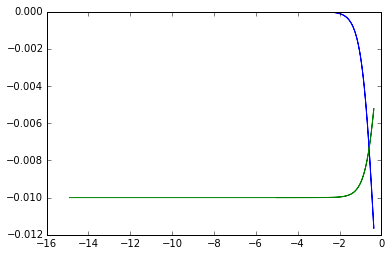

In [39]:
plt.plot(traj, forces)
plt.plot(traj, energies)

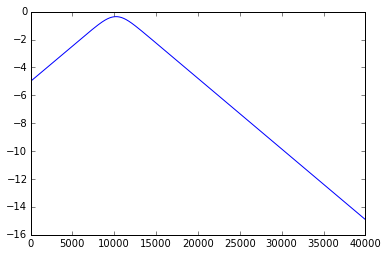

In [40]:
plt.plot(traj)

## Running a trajectory using MMST with no coupling

This should give the same results as the single surface.

In [4]:
import openmm_mmst as mmst

Hmat = [[sys11, sys00], [sys00, sys22]]
#mmst_integ = NonadiabaticIntegrator(Hmat)

## Running a trajectory with the real MMST

In [5]:
Hmat = [[sys11, sys12], [sys12, sys22]]
#mmst_integ = NonadiabaticIntegrator(Hmat)

In [174]:
f = simulation.system.getForce(0)